# Prédiction du niveau calorique des recettes avec Random Forest

Ce notebook utilise un classifieur Random Forest pour prédire le niveau calorique des recettes (BAS/MOYEN/HAUT) basé sur les ingrédients et instructions, avec préprocessing NLP et interprétation SHAP.

## Objectifs:
- Classifier les recettes en 3 niveaux caloriques (bas < 250, moyen 250-500, haut > 500)
- Utiliser Random Forest avec bonnes pratiques
- Préprocessing NLP des ingrédients et instructions
- Interprétation avec SHAP (explicabilité très importante dans la nutrition)

## 1. Imports

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import shap
import re
import ast
import warnings
warnings.filterwarnings('ignore')

# Configuration thème sombre harmonisé
plt.style.use('dark_background')
plt.rcParams['axes.unicode_minus'] = False

# Palette de couleurs magnifique
beautiful_colors = ['#FF6B9D', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF', '#5F27CD', '#A8E6CF', '#FFD93D']

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries importées avec succès avec thème sombre harmonisé!")


Libraries importées avec succès avec thème sombre harmonisé!


## 2. Chargement et exploration des données

In [57]:
# Chargement des données
df = pd.read_csv('data/RAW_recipes.csv')
print(f"Forme du dataset: {df.shape}")
print(f"\nColonnes: {df.columns.tolist()}")
print(f"\nPremières lignes:")
df.head()


Forme du dataset: (231637, 12)

Colonnes: ['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients']

Premières lignes:


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [58]:
# Informations sur le dataset
df.info()
print("\nValeurs manquantes:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB

Valeurs manquantes:
name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
ste

## 3. Préprocessing des données nutritionnelles

In [59]:
def parse_nutrition(nutrition_str):
    """Parse la colonne nutrition pour extraire les valeurs nutritionnelles"""
    try:
        # Convertir la chaîne en liste
        nutrition_list = ast.literal_eval(nutrition_str)
        return nutrition_list
    except:
        return [0, 0, 0, 0, 0, 0, 0]

# Appliquer le parsing
df['nutrition_parsed'] = df['nutrition'].apply(parse_nutrition)

# Extraire les valeurs nutritionnelles (l'ordre est: calories, total_fat, sugar, sodium, protein, saturated_fat, carbohydrates)
nutrition_columns = ['calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
for i, col in enumerate(nutrition_columns):
    df[col] = df['nutrition_parsed'].apply(lambda x: x[i] if len(x) > i else 0)

# Supprimer les valeurs aberrantes de calories (> 3000 ou < 0)
df = df[(df['calories'] >= 0) & (df['calories'] <= 3000)]

print(f"Statistiques des calories après nettoyage:")
print(df['calories'].describe())


Statistiques des calories après nettoyage:
count    228486.000000
mean        408.524812
std         384.645804
min           0.000000
25%         172.600000
50%         309.100000
75%         507.900000
max        2999.800000
Name: calories, dtype: float64


## 4. Analyse descriptive des calories


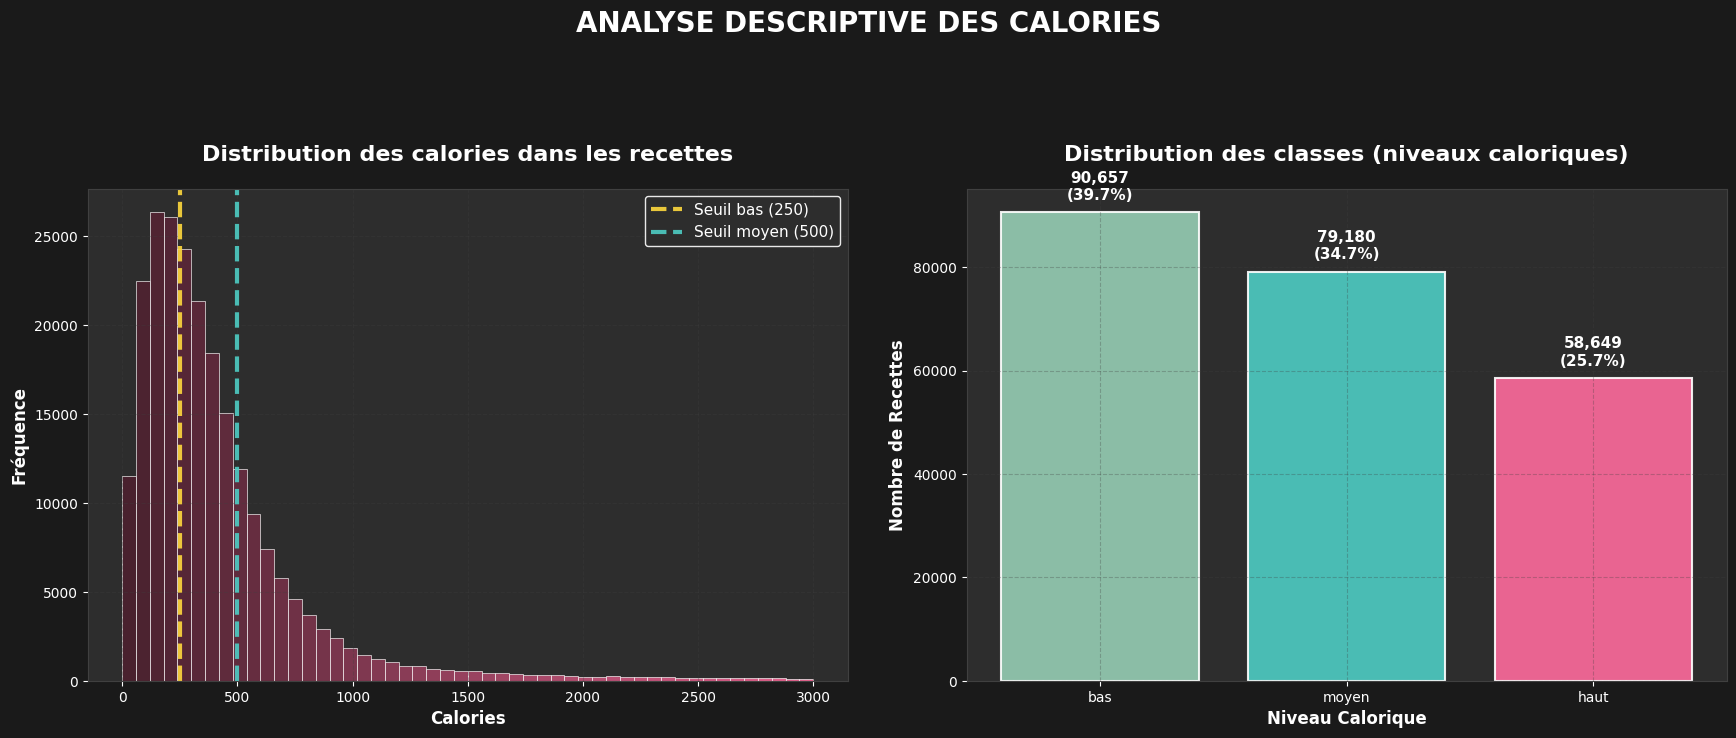

Distribution des niveaux caloriques:
calorie_level
bas      90657
moyen    79180
haut     58649
Name: count, dtype: int64

Pourcentages:
calorie_level
bas      39.677267
moyen    34.654202
haut     25.668531
Name: proportion, dtype: float64


In [60]:
def classify_calories(cal):
    """Classifie les calories en trois catégories"""
    if cal < 250:
        return 'bas'
    elif cal <= 500:
        return 'moyen'
    else:
        return 'haut'

# Créer la variable cible
df['calorie_level'] = df['calories'].apply(classify_calories)

# Visualisation harmonisée de la distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.patch.set_facecolor('#1a1a1a')  # Fond général

# 1. Distribution des calories avec style harmonisé
axes[0].set_facecolor('#2d2d2d')  # Fond du subplot
n, bins, patches = axes[0].hist(df['calories'], bins=50, alpha=0.9, 
                               edgecolor='white', linewidth=0.5)

# Appliquer un dégradé de couleurs
for i, patch in enumerate(patches):
    # Créer un dégradé avec la couleur principale
    base_color = np.array([255, 107, 157])  # #FF6B9D en RGB
    intensity = 0.3 + 0.7 * (i / len(patches))
    color = base_color * intensity / 255.0
    patch.set_facecolor(color)

axes[0].set_title('Distribution des calories dans les recettes', fontweight='bold', 
                 fontsize=16, color='white', pad=20)
axes[0].set_xlabel('Calories', fontweight='bold', color='white', fontsize=12)
axes[0].set_ylabel('Fréquence', fontweight='bold', color='white', fontsize=12)

# Lignes de seuil avec couleurs contrastantes
axes[0].axvline(x=250, color='#FFD93D', linestyle='--', linewidth=3, 
               alpha=0.9, label='Seuil bas (250)')
axes[0].axvline(x=500, color='#4ECDC4', linestyle='--', linewidth=3, 
               alpha=0.9, label='Seuil moyen (500)')

axes[0].tick_params(colors='white')
axes[0].grid(True, alpha=0.3, color='#404040', linestyle='--')

# Légende harmonisée
legend = axes[0].legend(framealpha=0.9, facecolor='#2d2d2d', 
                       edgecolor='white', fontsize=11)
for text in legend.get_texts():
    text.set_color('white')

# Style des bordures
for spine in axes[0].spines.values():
    spine.set_color('#404040')

# 2. Distribution des niveaux caloriques avec palette harmonisée
axes[1].set_facecolor('#2d2d2d')

calorie_counts = df['calorie_level'].value_counts()
# Ordre logique des catégories
ordered_levels = ['bas', 'moyen', 'haut']
ordered_counts = [calorie_counts.get(level, 0) for level in ordered_levels]

# Couleurs spécifiques pour chaque catégorie
level_colors = ['#96CEB4', '#4ECDC4', '#FF6B9D']  # Vert, Cyan, Rose

bars = axes[1].bar(ordered_levels, ordered_counts, 
                   color=level_colors, alpha=0.9, 
                   edgecolor='white', linewidth=1.5)

axes[1].set_title('Distribution des classes (niveaux caloriques)', 
                 fontweight='bold', fontsize=16, color='white', pad=20)
axes[1].set_xlabel('Niveau Calorique', fontweight='bold', color='white', fontsize=12)
axes[1].set_ylabel('Nombre de Recettes', fontweight='bold', color='white', fontsize=12)

# Ajouter les valeurs sur les barres avec style
for i, (bar, count) in enumerate(zip(bars, ordered_counts)):
    percentage = (count / sum(ordered_counts)) * 100
    axes[1].text(bar.get_x() + bar.get_width()/2, 
                bar.get_height() + max(ordered_counts)*0.02,
                f'{count:,}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', 
                color='white', fontsize=11)

axes[1].tick_params(colors='white')
axes[1].grid(True, alpha=0.3, color='#404040', linestyle='--')

# Style des bordures
for spine in axes[1].spines.values():
    spine.set_color('#404040')

# Ajustement harmonisé avec titre général
fig.suptitle('ANALYSE DESCRIPTIVE DES CALORIES', 
             fontsize=20, fontweight='bold', color='white', y=0.98)

plt.tight_layout(pad=3.0, rect=[0, 0.03, 1, 0.95])
plt.show()

print("Distribution des niveaux caloriques:")
print(df['calorie_level'].value_counts())
print("\nPourcentages:")
print(df['calorie_level'].value_counts(normalize=True) * 100)


## 5. Préprocessing NLP des ingrédients et instructions

In [76]:
def clean_text_simple(text):
    if pd.isna(text):
        return ""
    
    # Convertir en string si ce n'est pas déjà fait
    text = str(text)
    
    # Supprimer les crochets et guillemets
    text = re.sub(r"[\[\]'\"]", "", text)
    
    # Remplacer les virgules par des séparateurs pipe
    text = re.sub(r",", " | ", text)
    
    # Supprimer les caractères spéciaux sauf les espaces et pipes
    text = re.sub(r"[^a-zA-Z0-9\s|]", "", text)
    
    # Convertir en minuscules
    text = text.lower()
    
    # Supprimer les espaces multiples
    text = re.sub(r"\s+", " ", text)
    
    # Nettoyer les espaces autour des pipes
    text = re.sub(r"\s*\|\s*", " | ", text)

    return text.strip()

# Téléchargement des ressources NLTK
print("Téléchargement des ressources NLTK...")
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)  # Version récente de punkt
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)  # Pour WordNet multilingue
print("Ressources NLTK téléchargées!")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Configuration NLTK avec stop words culinaires personnalisés
stop_words = set(stopwords.words('english'))

# Ajouter des stop words spécifiques à la cuisine
culinary_stopwords = {
    'bake', 'baking', 'chopped', 'coarse', 'coarsely', 'cook', 'cooking', 
    'cube', 'cubes', 'cup', 'cups', 'cut', 'diced', 'divided', 'finely', 
    'gram', 'grams', 'grated', 'halved', 'hour', 'hours', 'inch', 'inches', 
    'kg', 'lengthwise', 'liter', 'liters', 'melted', 'minute', 'minutes', 
    'minced', 'ml', 'oz', 'peeled', 'piece', 'pieces', 'plus', 'pound', 
    'pounds', 'quartered', 'recipe', 'recipes', 'room', 'seeded', 'serve', 
    'serves', 'serving', 'servings', 'sliced', 'stick', 'tablespoon', 
    'tablespoons', 'tbsp', 'teaspoon', 'teaspoons', 'temperature', 'thinly', 
    'tsp', 'trimmed', 'fresh', 'large', 'small', 'medium', 'whole', 'half',
    'quarter', 'taste', 'optional', 'needed', 'desired', 'prepare', 'prepared'
}

# Fusionner les stop words
# stop_words.update(culinary_stopwords)

print(f"Stop words enrichis: {len(stop_words)} mots au total")
print(f"Stop words culinaires ajoutés: {len(culinary_stopwords)} mots")

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Nettoyage avancé du texte avec NLTK, lemmatisation et tri alphabétique
    """
    if pd.isna(text) or text == '':
        return ''
    
    # Convertir en string et minuscules
    text = str(text).lower()
    
    # Supprimer les crochets et guillemets d'abord
    text = re.sub(r"[\[\]'\"]", "", text)
    
    # Supprimer la ponctuation et caractères spéciaux
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Supprimer les chiffres (quantités)
    # text = re.sub(r'\d+', '', text)
    
    # Tokenisation
    tokens = word_tokenize(text)
    
    # Supprimer stopwords et mots courts (< 3 caractères)
    tokens = [token for token in tokens if token not in stop_words and (len(token) > 2 or token.isdigit())]
    
    # Lemmatisation
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Supprimer les doublons et trier alphabétiquement
    #unique_tokens = sorted(set(tokens))
    unique_tokens = set(tokens)
    
    return ' '.join(unique_tokens)

def sort_ingredients(ingredients_text):
    """
    Trie les ingrédients par ordre alphabétique avant nettoyage
    """
    try:
        # Convertir la chaîne en liste
        ingredients_list = ast.literal_eval(ingredients_text)
        
        # Trier par ordre alphabétique
        sorted_ingredients = sorted(ingredients_list)
        
        # Retourner comme chaîne
        return str(sorted_ingredients)
    except:
        # Si échec, retourner tel quel
        return ingredients_text

# Test de la fonction optimisée
test_ingredient = "['2 cups chopped fresh spinach', '1 large diced tomato', '3 cloves minced garlic', '1/4 cup olive oil']"
print(f"\nTest de la fonction optimisée:")
print(f"Avant: {test_ingredient}")
print(f"Après: {clean_text_simple(test_ingredient)}")

# Nettoyer les ingrédients avec la fonction optimisée
print(f"\nNettoyage des ingrédients en cours...")
df['ingredients_sorted'] = df['ingredients'].apply(sort_ingredients)
df['ingredients_cleaned'] = df['ingredients_sorted'].apply(clean_text_simple)

# Supprimer les recettes avec du texte vide
df = df[df['ingredients_cleaned'].str.len() > 10]

print(f"Nombre de recettes après nettoyage avancé: {len(df)}")
print("\nExemple de texte nettoyé et optimisé:")
print(df['ingredients_cleaned'].iloc[0][:200] + "...")

# Statistiques d'amélioration
print(f"\nStatistiques d'amélioration:")
word_counts = df['ingredients_cleaned'].apply(lambda x: len(x.split()))
print(f"Nombre moyen de mots par recette: {word_counts.mean():.1f}")
print(f"Nombre médian de mots par recette: {word_counts.median():.1f}")
print(f"Recettes avec moins de 5 mots: {(word_counts < 5).sum():,}")
print(f"Recettes avec 5-15 mots: {((word_counts >= 5) & (word_counts <= 15)).sum():,}")
print(f"Recettes avec plus de 15 mots: {(word_counts > 15).sum():,}")

Téléchargement des ressources NLTK...
Ressources NLTK téléchargées!
Stop words enrichis: 198 mots au total
Stop words culinaires ajoutés: 72 mots

Test de la fonction optimisée:
Avant: ['2 cups chopped fresh spinach', '1 large diced tomato', '3 cloves minced garlic', '1/4 cup olive oil']
Après: 2 cups chopped fresh spinach | 1 large diced tomato | 3 cloves minced garlic | 14 cup olive oil

Nettoyage des ingrédients en cours...
Nombre de recettes après nettoyage avancé: 228416

Exemple de texte nettoyé et optimisé:
butter | honey | mexican seasoning | mixed spice | olive oil | salt | winter squash...

Statistiques d'amélioration:
Nombre moyen de mots par recette: 24.5
Nombre médian de mots par recette: 23.0
Recettes avec moins de 5 mots: 899
Recettes avec 5-15 mots: 46,665
Recettes avec plus de 15 mots: 180,852


## 6. Vectorisation TF-IDF et préparation des données

In [62]:
# LabelEncoder pour les classes, et en plus ça garantit l'ordre des classes
le = LabelEncoder()
le.fit(['bas', 'moyen', 'haut'])

y_encoded = le.transform(df['calorie_level'])

# Paramètres TF-IDF optimisés
tfidf = TfidfVectorizer(
    max_features=5000,  # Limiter le nombre de features
    min_df=5,          # Ignorer les termes qui apparaissent dans moins de 5 documents
    max_df=0.8,        # Ignorer les termes qui apparaissent dans plus de 80% des documents
    stop_words='english',
    ngram_range=(1, 2)  # Utiliser des unigrammes et bigrammes
)

# Vectoriser le texte
X_tfidf = tfidf.fit_transform(df['ingredients_cleaned'])
print(f"Forme de la matrice TF-IDF: {X_tfidf.shape}")

# Préparer les variables
X = X_tfidf
y = y_encoded

# Division des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Taille du jeu d'entraînement: {X_train.shape[0]}")
print(f"Taille du jeu de test: {X_test.shape[0]}")
print(f"\nDistribution dans le jeu d'entraînement:")
for i, classe in enumerate(le.classes_):
    count = (y_train == i).sum()
    percentage = (y_train == i).mean() * 100
    print(f"{classe}: {count:,} ({percentage:.1f}%)")


Forme de la matrice TF-IDF: (228416, 5000)
Taille du jeu d'entraînement: 182732
Taille du jeu de test: 45684

Distribution dans le jeu d'entraînement:
bas: 72,485 (39.7%)
haut: 46,914 (25.7%)
moyen: 63,333 (34.7%)


## 7. Optimisation des Hyperparamètres avec GridSearchCV

In [63]:
"""
# Conf de test très rapide
param_grid = {
    'n_estimators': [100],
    'max_depth': [20], 
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'class_weight': ['balanced']
}

# Conf de prod
param_grid = {
    'n_estimators': [200, 300],           
    'max_depth': [20, None],              
    'min_samples_split': [2, 5],         
    'min_samples_leaf': [1, 2],        
    'class_weight': ['balanced'] # Ajout pour gérer déséquilibre des classes
}
"""

print("Initialisation du GridSearchCV...")
# Définir les paramètres à optimiser
param_grid = {
    'n_estimators': [100],
    'max_depth': [20], 
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'class_weight': ['balanced']
}

# Créer le modèle de base
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Recherche par grille avec validation croisée réduite
print("Optimisation des hyperparamètres en cours...")
print(f"Nombre de combinaisons: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])}")

grid_search = GridSearchCV(
    rf_base, 
    param_grid, 
    cv=3, # 3 folds
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score de validation croisée: {grid_search.best_score_:.4f}")

# Utiliser le meilleur modèle
best_rf = grid_search.best_estimator_


Initialisation du GridSearchCV...
Optimisation des hyperparamètres en cours...
Nombre de combinaisons: 1
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Meilleurs paramètres: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Meilleur score de validation croisée: 0.5151


## 8. Évaluation du modèle

Accuracy d'entraînement: 0.6229
Accuracy de test: 0.5137

Rapport de classification (jeu de test):
              precision    recall  f1-score   support

         bas       0.56      0.72      0.63     18121
       moyen       0.47      0.45      0.46     11729
        haut       0.47      0.32      0.38     15834

    accuracy                           0.51     45684
   macro avg       0.50      0.50      0.49     45684
weighted avg       0.50      0.51      0.50     45684



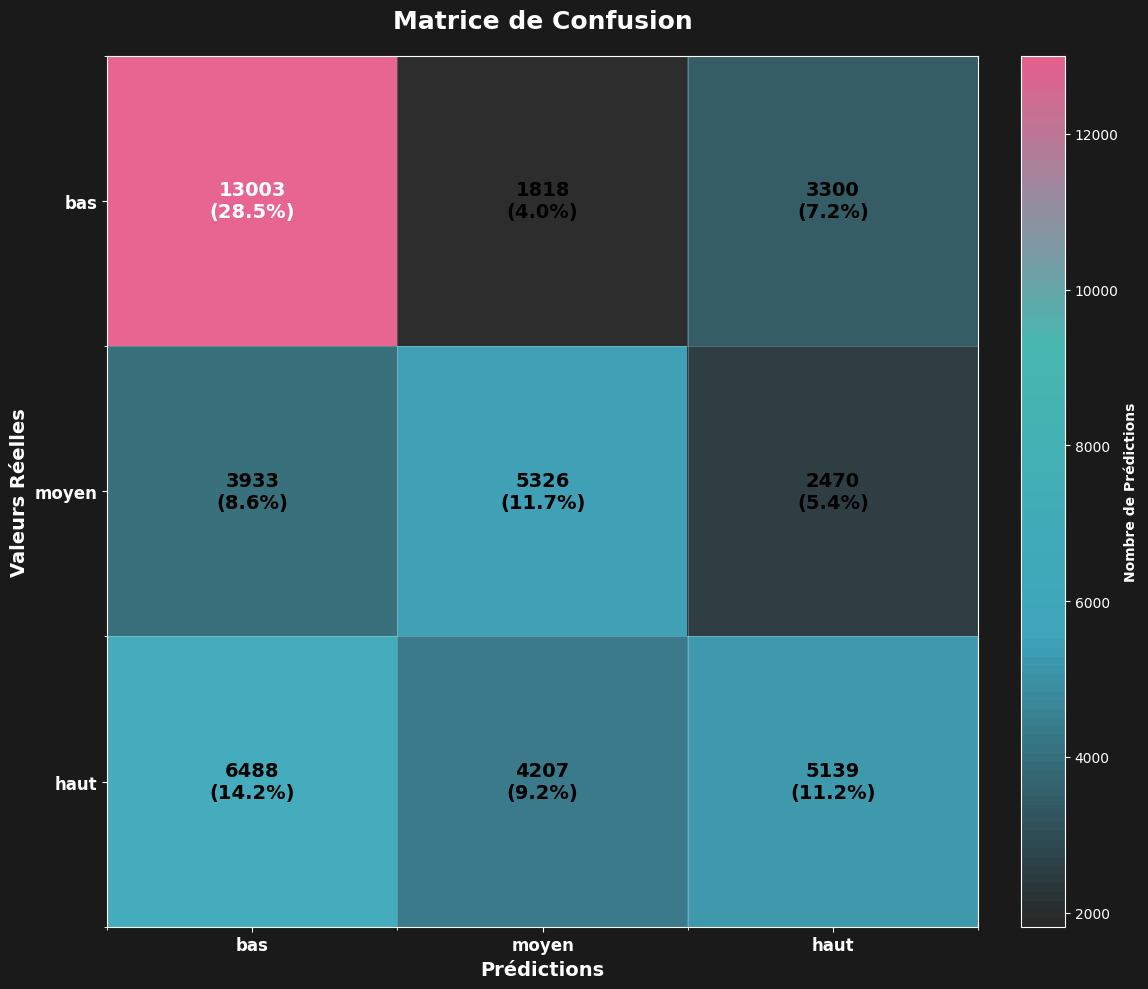


Scores de validation croisée: [0.51878403 0.51774427 0.51718382 0.51614404 0.5159525 ]
Score moyen: 0.5172 (+/- 0.0021)


In [64]:
# Prédictions
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# Scores d'accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Accuracy d'entraînement: {train_accuracy:.4f}")
print(f"Accuracy de test: {test_accuracy:.4f}")

# Rapport de classification
print("\nRapport de classification (jeu de test):")
print(classification_report(y_test, y_pred_test, target_names=['bas', 'moyen', 'haut']))

# Matrice de confusion harmonisée
fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#2d2d2d')

cm = confusion_matrix(y_test, y_pred_test)

# Créer un heatmap personnalisé avec des couleurs harmonisées
# Utiliser une palette dégradée du thème
import matplotlib.colors as mcolors

# Créer une colormap personnalisée
colors = ['#2d2d2d', '#45B7D1', '#4ECDC4', '#FF6B9D']
n_bins = 100
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Heatmap avec style personnalisé
im = ax.imshow(cm, interpolation='nearest', cmap=cmap, alpha=0.9)

# Annotations avec style
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, f'{cm[i, j]}\n({cm[i, j]/cm.sum()*100:.1f}%)',
                ha='center', va='center', fontweight='bold',
                color=text_color, fontsize=14)

# Labels harmonisés
class_names = ['bas', 'moyen', 'haut']
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, fontsize=12, color='white', fontweight='bold')
ax.set_yticklabels(class_names, fontsize=12, color='white', fontweight='bold')

# Titres et labels
ax.set_title('Matrice de Confusion', fontsize=18, fontweight='bold', 
             color='white', pad=20)
ax.set_xlabel('Prédictions', fontsize=14, fontweight='bold', color='white')
ax.set_ylabel('Valeurs Réelles', fontsize=14, fontweight='bold', color='white')

# Colorbar harmonisée
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_tick_params(color='white')
cbar.ax.tick_params(labelcolor='white')
cbar.set_label('Nombre de Prédictions', color='white', fontweight='bold')

# Grille subtile
ax.set_xticks(np.arange(len(class_names) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(class_names) + 1) - 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# Validation croisée
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nScores de validation croisée: {cv_scores}")
print(f"Score moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


## 9. Importance des features

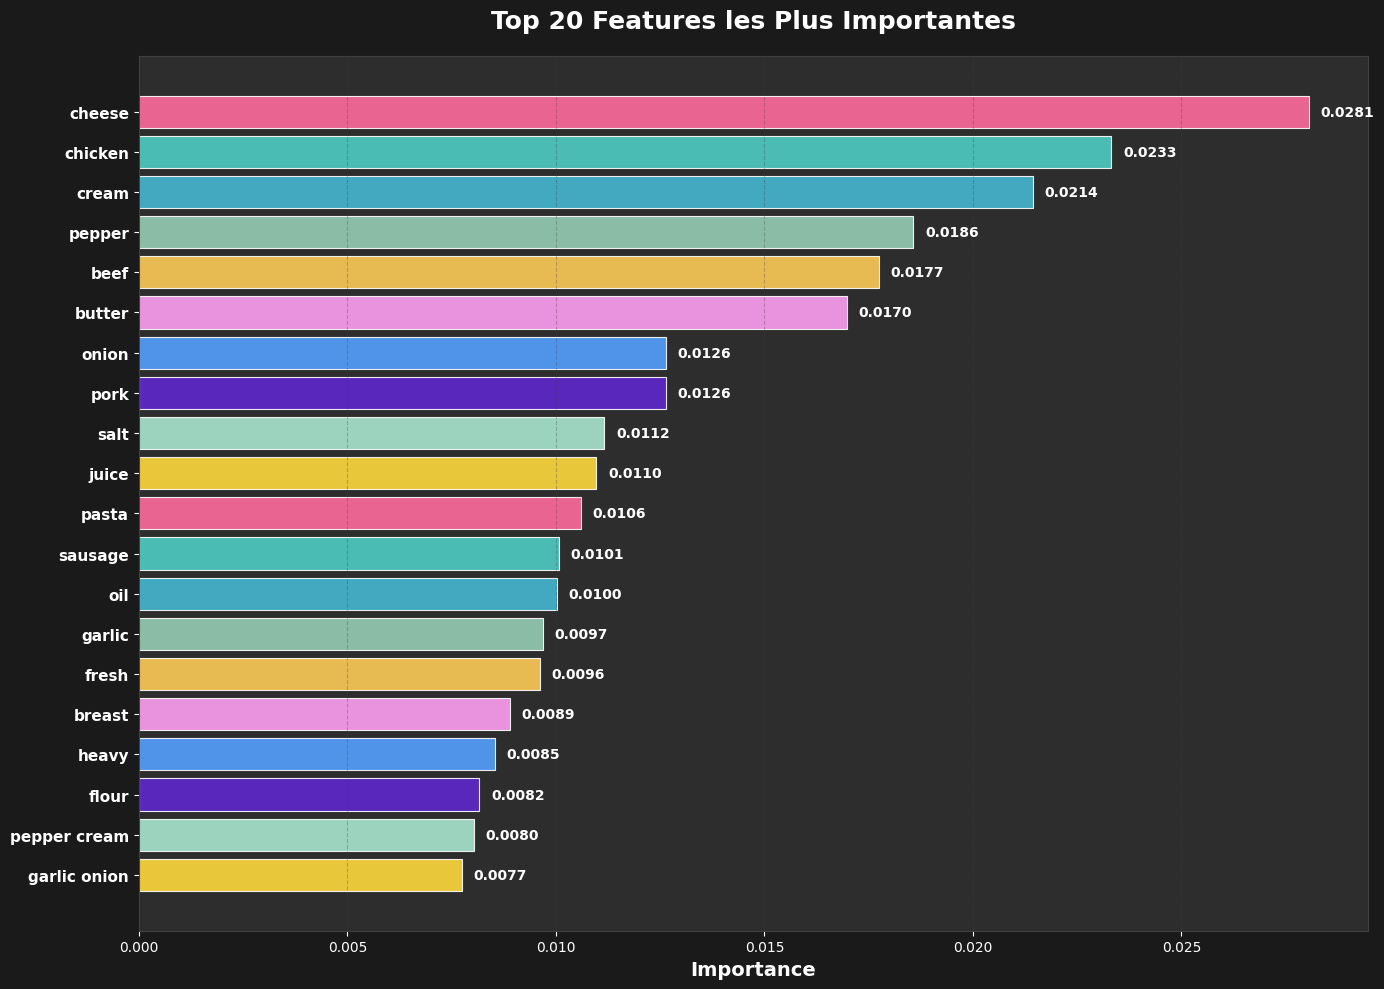

Top 10 des features les plus importantes:
      feature  importance
782    cheese    0.028064
875   chicken    0.023324
1262    cream    0.021432
3247   pepper    0.018572
257      beef    0.017749
558    butter    0.016985
2981    onion    0.012636
3424     pork    0.012631
3784     salt    0.011161
2255    juice    0.010967


In [65]:
# Obtenir les noms des features
feature_names = tfidf.get_feature_names_out()
feature_importance = best_rf.feature_importances_

# Créer un DataFrame pour les importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Graphique harmonisé des features importantes
fig, ax = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#2d2d2d')

top_features = importance_df.head(20)

# Créer les barres horizontales avec palette harmonisée
colors = [beautiful_colors[i % len(beautiful_colors)] for i in range(len(top_features))]
bars = ax.barh(range(len(top_features)), top_features['importance'],
               color=colors, alpha=0.9, 
               edgecolor='white', linewidth=0.8)

# Configuration des axes
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=11, color='white', fontweight='bold')
ax.set_xlabel('Importance', fontweight='bold', color='white', fontsize=14)
ax.set_title('Top 20 Features les Plus Importantes', 
             fontweight='bold', fontsize=18, color='white', pad=20)

# Ajouter les valeurs sur les barres
for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
    ax.text(bar.get_width() + max(top_features['importance'])*0.01, 
            bar.get_y() + bar.get_height()/2, 
            f'{importance:.4f}', 
            ha='left', va='center', fontweight='bold', 
            color='white', fontsize=10)

# Style harmonisé
ax.invert_yaxis()
ax.tick_params(colors='white')
ax.grid(True, alpha=0.3, color='#404040', linestyle='--', axis='x')

# Bordures harmonisées
for spine in ax.spines.values():
    spine.set_color('#404040')

plt.tight_layout()
plt.show()

print("Top 10 des features les plus importantes:")
print(importance_df.head(10))


## 10. Analyse SHAP pour l'explicabilité

Initialisation de l'explainer SHAP...
Calcul des valeurs SHAP pour 100 échantillons...
Analyse SHAP terminée!


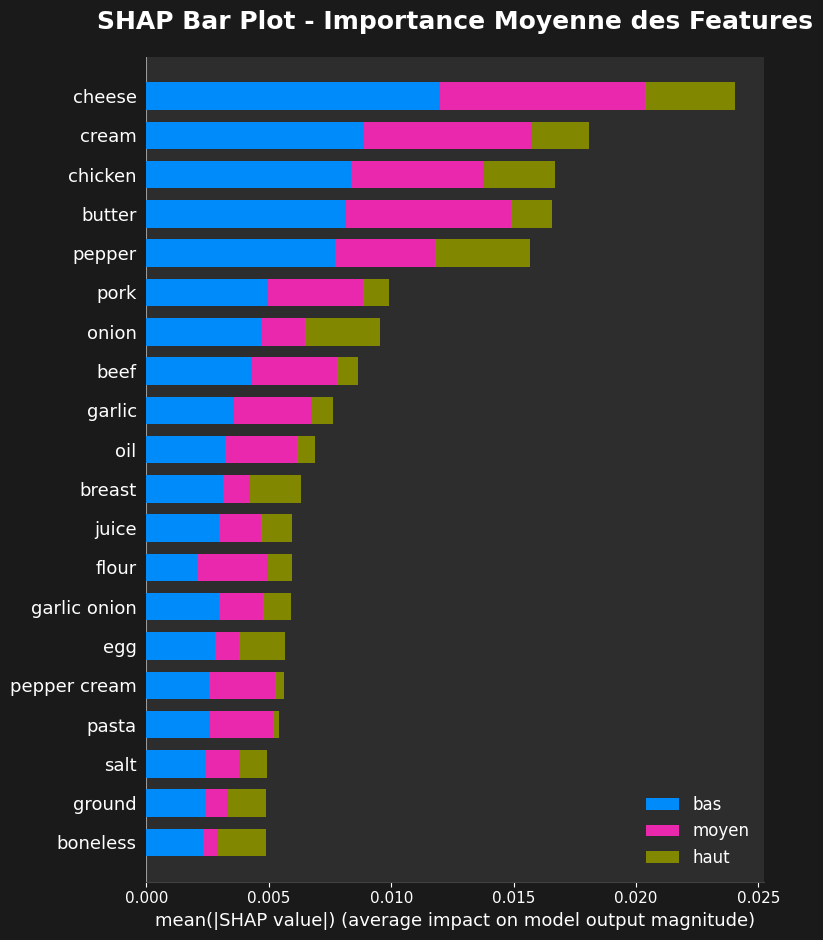

In [66]:
# Initialiser l'explainer SHAP
print("Initialisation de l'explainer SHAP...")
explainer = shap.TreeExplainer(best_rf)

# Calculer les valeurs SHAP sur un échantillon
sample_size = min(100, X_test.shape[0])
X_test_sample = X_test[:sample_size].toarray().astype(np.float64)  # Conversion directe
# y_test_sample = y_test.iloc[:sample_size]
y_test_sample = y_test[:sample_size]

print(f"Calcul des valeurs SHAP pour {sample_size} échantillons...")
shap_values = explainer.shap_values(X_test_sample)

print("Analyse SHAP terminée!")

# Bar plot SHAP
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('#1a1a1a')

shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                  plot_type="bar", class_names=['bas', 'moyen', 'haut'], show=False)

# Styles
ax = plt.gca()
ax.set_facecolor('#2d2d2d')
ax.set_title('SHAP Bar Plot - Importance Moyenne des Features', 
             fontweight='bold', fontsize=18, color='white', pad=20)

ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

for spine in ax.spines.values():
    spine.set_color('#404040')

plt.tight_layout()
plt.show()


## 11. Prédictions

In [67]:
def predict_calorie_level(ingredients_text):
    """
    Prédit le niveau calorique d'une recette basé sur les ingrédients
    
    Args:
        ingredients_text (str): Liste des ingrédients
    
    Returns:
        tuple: (prédiction, probabilités)
    """
    # Nettoyer le texte
    ingredients_cleaned = clean_text(ingredients_text)
 
    # Vectoriser
    text_vectorized = tfidf.transform([ingredients_cleaned])
    
    # Prédire
    prediction_encoded = best_rf.predict(text_vectorized)[0]
    probabilities = best_rf.predict_proba(text_vectorized)[0]
    
    # Décoder la prédiction
    prediction = le.inverse_transform([prediction_encoded])[0]
    
    # Créer le dictionnaire avec les vrais noms
    prob_dict = dict(zip(['bas', 'moyen', 'haut'], probabilities))
    
    return prediction, prob_dict

def visualize_prediction(ingredients_text):
    """
    Visualise une prédiction avec le thème harmonisé
    
    Args:
        ingredients_text (str): Liste des ingrédients
    """
    # Prédiction
    prediction, prob_dict = predict_calorie_level(ingredients_text)
    
    # Créer la figure harmonisée
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    fig.patch.set_facecolor('#1a1a1a')
    
    # 1. Graphique des probabilités (camembert)
    ax1.set_facecolor('#2d2d2d')
    
    # Couleurs spécifiques pour chaque catégorie
    category_colors = {'bas': '#96CEB4', 'moyen': '#4ECDC4', 'haut': '#FF6B9D'}
    colors = [category_colors[cat] for cat in prob_dict.keys()]
    
    # Mettre en évidence la prédiction
    explode = [0.1 if cat == prediction else 0 for cat in prob_dict.keys()]
    
    wedges, texts, autotexts = ax1.pie(prob_dict.values(), 
                                      labels=[f'{cat.upper()}\n{prob:.1%}' for cat, prob in prob_dict.items()],
                                      colors=colors, explode=explode, autopct='',
                                      shadow=True, startangle=90,
                                      textprops={'fontsize': 12, 'color': 'white', 'fontweight': 'bold'})
    
    ax1.set_title(f'Prédiction: {prediction.upper()}', 
                 fontweight='bold', fontsize=16, color='white', pad=20)
    
    # 2. Graphique en barres des probabilités
    ax2.set_facecolor('#2d2d2d')
    
    categories = list(prob_dict.keys())
    probabilities = list(prob_dict.values())
    colors_bars = [category_colors[cat] for cat in categories]
    
    bars = ax2.bar(categories, probabilities, color=colors_bars, alpha=0.9,
                   edgecolor='white', linewidth=1.5)
    
    # Mettre en évidence la prédiction
    for i, (bar, cat) in enumerate(zip(bars, categories)):
        if cat == prediction:
            bar.set_edgecolor('#FFD93D')
            bar.set_linewidth(3)
        
        # Ajouter les valeurs
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{probabilities[i]:.1%}', ha='center', va='bottom',
                fontweight='bold', color='white', fontsize=12)
    
    ax2.set_title('Probabilités par Catégorie', 
                 fontweight='bold', fontsize=16, color='white', pad=20)
    ax2.set_ylabel('Probabilité', fontweight='bold', color='white')
    ax2.tick_params(colors='white')
    ax2.grid(True, alpha=0.3, color='#404040', linestyle='--')
    
    for spine in ax2.spines.values():
        spine.set_color('#404040')
    
    # Texte des ingrédients
    ax3.set_facecolor('#2d2d2d')
    ax3.axis('off')
    
    # Nettoyer et formater les ingrédients
    ingredients_clean = clean_text(ingredients_text)
    ingredients_words = ingredients_clean.split()
    
    # Créer un texte formaté
    ingredients_display = ', '.join(ingredients_words[:10])  # Limiter à 10 mots
    if len(ingredients_words) > 10:
        ingredients_display += f"... (+{len(ingredients_words) - 10} mots)"
    
    info_text = f"""ANALYSE DE LA RECETTE

Prédiction: {prediction.upper()}
Confiance: {max(prob_dict.values()):.1%}

Ingrédients analysés:
{ingredients_display}

Nombre de termes: {len(ingredients_words)}
Longueur du texte: {len(ingredients_text)} caractères"""
    
    ax3.text(0.05, 0.95, info_text, transform=ax3.transAxes, 
             fontsize=11, color='white', va='top', ha='left',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='#404040', alpha=0.8))
    
    # Graphique des top features de cette prédiction
    ax4.set_facecolor('#2d2d2d')
    
    # Obtenir les features de ce texte
    text_vectorized = tfidf.transform([ingredients_clean])
    
    # Trouver les top features non-nulles
    if text_vectorized.nnz > 0:  # Si il y a des features non-nulles
        feature_indices = text_vectorized.nonzero()[1]
        feature_scores = text_vectorized.data
        
        # Créer un DataFrame des features de cette prédiction
        prediction_features = pd.DataFrame({
            'feature': [feature_names[i] for i in feature_indices],
            'score': feature_scores
        }).sort_values('score', ascending=False).head(10)
        
        colors_features = [beautiful_colors[i % len(beautiful_colors)] for i in range(len(prediction_features))]
        bars = ax4.barh(range(len(prediction_features)), prediction_features['score'],
                       color=colors_features, alpha=0.9, 
                       edgecolor='white', linewidth=0.8)
        
        ax4.set_yticks(range(len(prediction_features)))
        ax4.set_yticklabels(prediction_features['feature'], fontsize=10, color='white')
        ax4.set_xlabel('Score TF-IDF', fontweight='bold', color='white')
        ax4.set_title('Top Features de cette Recette', 
                     fontweight='bold', fontsize=14, color='white', pad=15)
        
        # Ajouter les valeurs
        for i, (bar, score) in enumerate(zip(bars, prediction_features['score'])):
            ax4.text(bar.get_width() + max(prediction_features['score'])*0.02, 
                    bar.get_y() + bar.get_height()/2, 
                    f'{score:.3f}', 
                    ha='left', va='center', fontweight='bold', 
                    color='white', fontsize=9)
        
        ax4.invert_yaxis()
        ax4.tick_params(colors='white')
        ax4.grid(True, alpha=0.3, color='#404040', linestyle='--', axis='x')
    else:
        ax4.text(0.5, 0.5, 'Aucune feature trouvée', ha='center', va='center',
                transform=ax4.transAxes, color='white', fontsize=14)
    
    # Bordures
    for spine in ax4.spines.values():
        spine.set_color('#404040')
    
    # Titre général
    fig.suptitle(f'PRÉDICTION: {prediction.upper()} (Confiance: {max(prob_dict.values()):.1%})', 
                 fontsize=20, fontweight='bold', color='white', y=0.98)
    
    plt.tight_layout(pad=3.0, rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return prediction, prob_dict

# Tester les fonctions avec quelques exemples
print("EXEMPLES DE PRÉDICTIONS:")
print("=" * 50)

# Exemple 1: Recette riche en calories
exemple1_ingredients = "butter, heavy cream, sugar, eggs, chocolate, flour, nuts"
pred1, prob1 = predict_calorie_level(exemple1_ingredients)
print(f"\nExemple 1 - Dessert riche:")
print(f"Ingrédients: {exemple1_ingredients}")
print(f"Prédiction: {pred1}")
print(f"Probabilités: {prob1}")

# Exemple 2: Recette légère
exemple2_ingredients = "spinach, tomatoes, onion, garlic, olive oil, herbs"
pred2, prob2 = predict_calorie_level(exemple2_ingredients)
print(f"\nExemple 2 - Plat léger:")
print(f"Ingrédients: {exemple2_ingredients}")
print(f"Prédiction: {pred2}")
print(f"Probabilités: {prob2}")

# Exemple 3: Recette moyenne
exemple3_ingredients = "chicken breast, rice, vegetables, olive oil, spices"
pred3, prob3 = predict_calorie_level(exemple3_ingredients)
print(f"\nExemple 3 - Plat équilibré:")
print(f"Ingrédients: {exemple3_ingredients}")
print(f"Prédiction: {pred3}")
print(f"Probabilités: {prob3}")
print("=" * 50)

print("\nTest de la fonction de visualisation harmonisée...")
print("=" * 60)

EXEMPLES DE PRÉDICTIONS:

Exemple 1 - Dessert riche:
Ingrédients: butter, heavy cream, sugar, eggs, chocolate, flour, nuts
Prédiction: haut
Probabilités: {'bas': np.float64(0.2877681880504693), 'moyen': np.float64(0.3895600191482217), 'haut': np.float64(0.3226717928012441)}

Exemple 2 - Plat léger:
Ingrédients: spinach, tomatoes, onion, garlic, olive oil, herbs
Prédiction: bas
Probabilités: {'bas': np.float64(0.39364795170821937), 'moyen': np.float64(0.2809171635936382), 'haut': np.float64(0.32543488469806453)}

Exemple 3 - Plat équilibré:
Ingrédients: chicken breast, rice, vegetables, olive oil, spices
Prédiction: moyen
Probabilités: {'bas': np.float64(0.2742193679928285), 'moyen': np.float64(0.35877581344956766), 'haut': np.float64(0.3670048185575519)}

Test de la fonction de visualisation harmonisée...



Exemple 1 - Dessert riche:
Ingrédients: butter, heavy cream, sugar, eggs, chocolate, flour, vanilla extract, cocoa powder, nuts


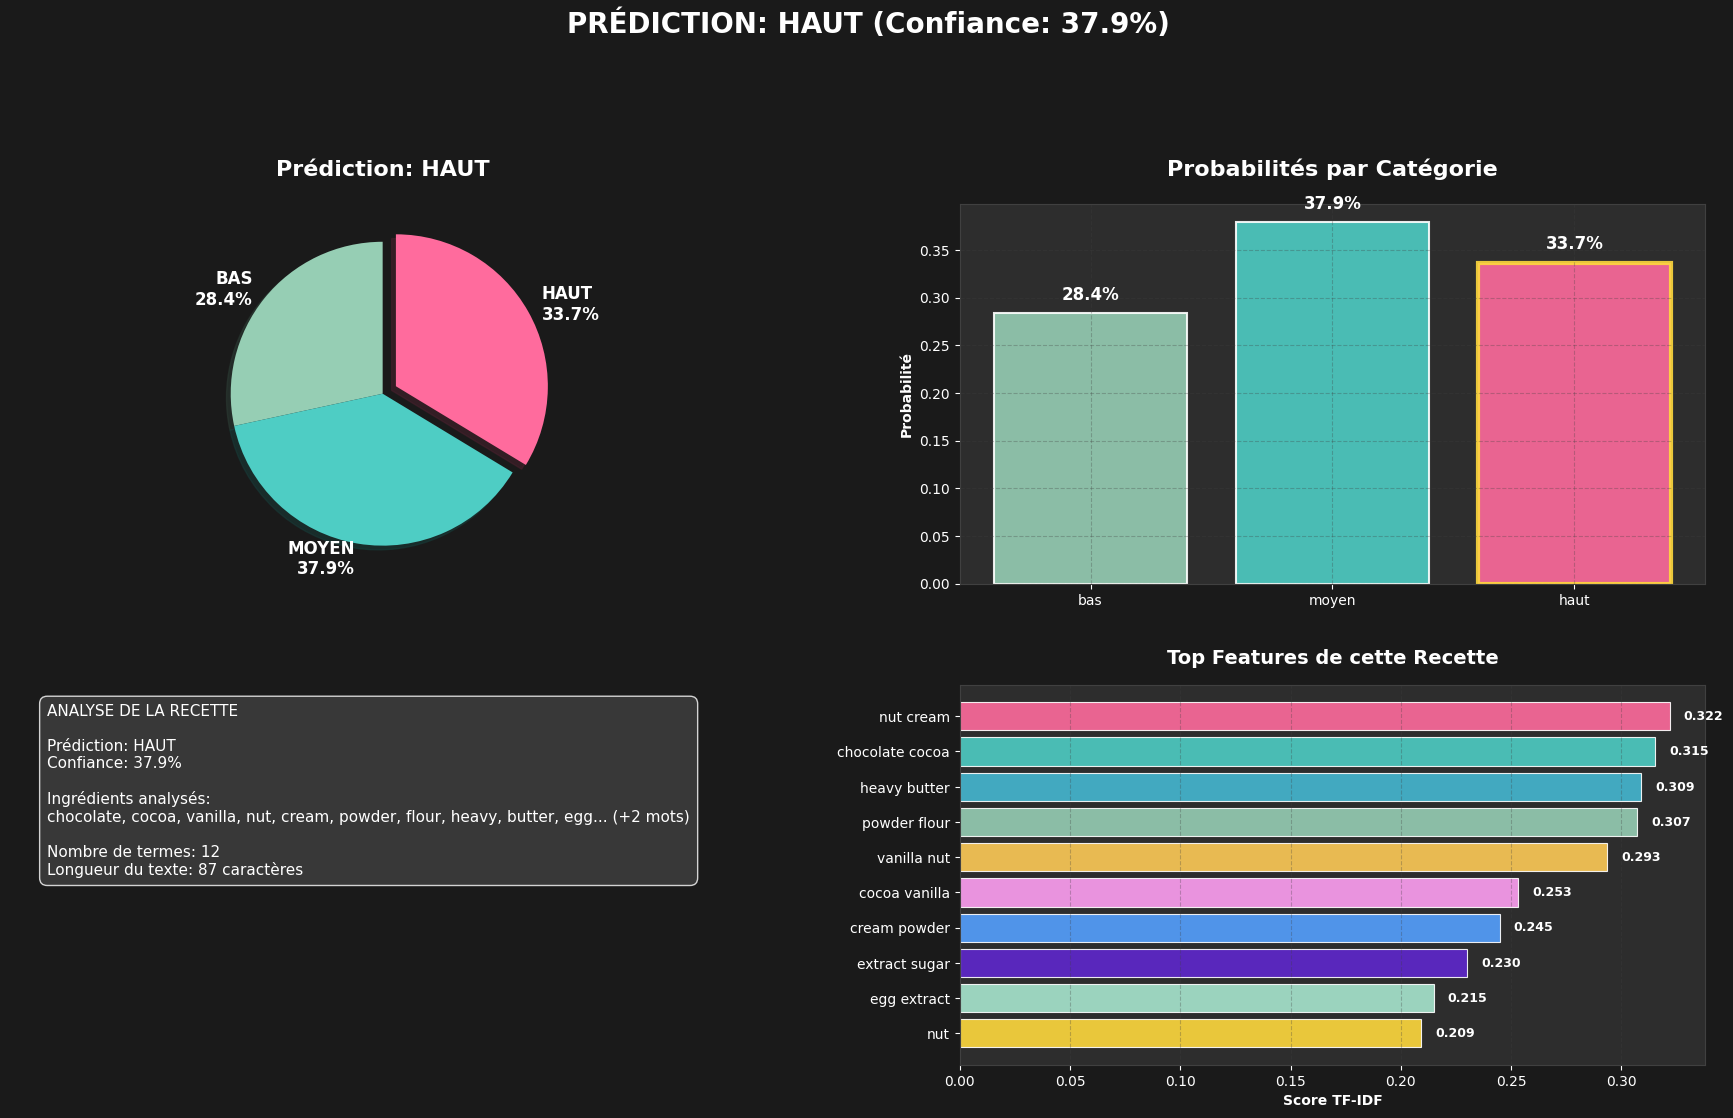

In [68]:
# Exemple avec un dessert riche
dessert_ingredients = "butter, heavy cream, sugar, eggs, chocolate, flour, vanilla extract, cocoa powder, nuts"
print(f"\nExemple 1 - Dessert riche:")
print(f"Ingrédients: {dessert_ingredients}")
pred1, prob1 = visualize_prediction(dessert_ingredients)


Exemple 2 - Salade légère:
Ingrédients: lettuce, tomatoes, cucumber, onion, olive oil, vinegar, herbs, salt, pepper


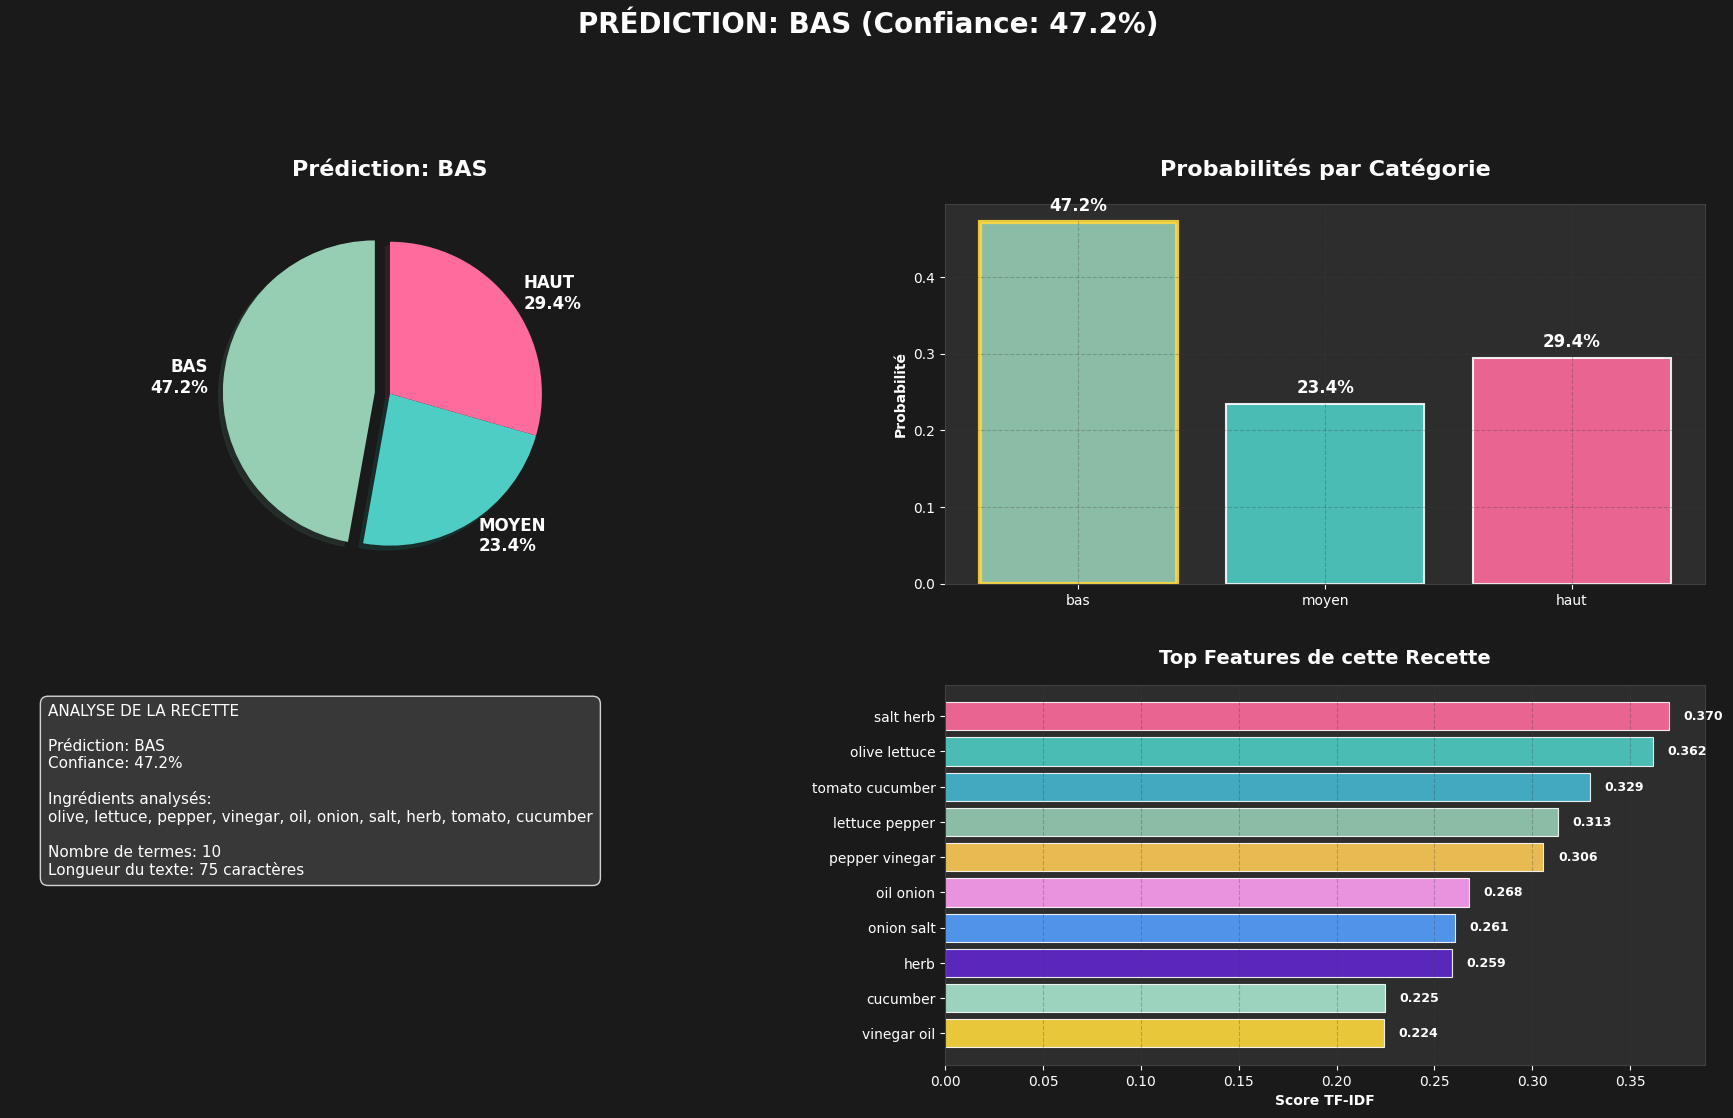

In [69]:
# Exemple avec une salade légère
salade_ingredients = "lettuce, tomatoes, cucumber, onion, olive oil, vinegar, herbs, salt, pepper"
print(f"\nExemple 2 - Salade légère:")
print(f"Ingrédients: {salade_ingredients}")
pred2, prob2 = visualize_prediction(salade_ingredients)



Exemple 3 - Plat équilibré:
Ingrédients: chicken breast, rice, broccoli, carrots, olive oil, garlic, onion, soy sauce, herbs


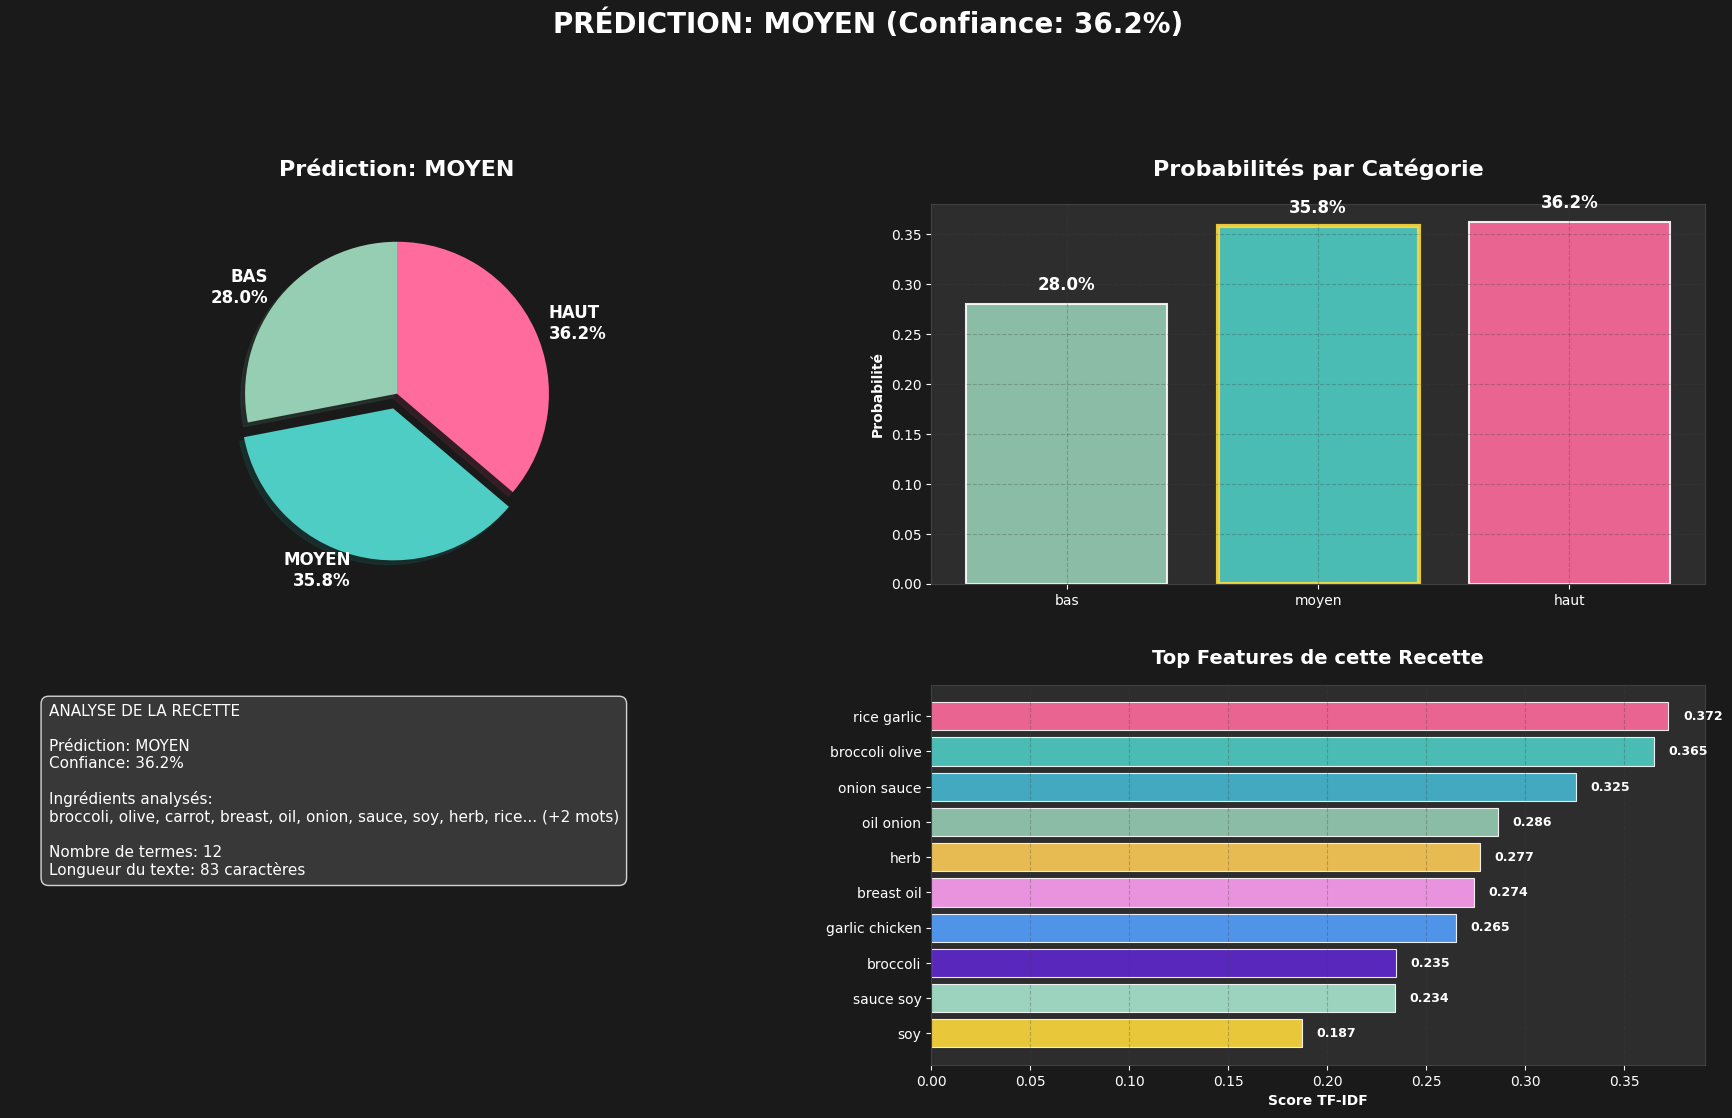


Visualisations harmonisées terminées!


In [70]:
# Exemple avec un plat équilibré
plat_ingredients = "chicken breast, rice, broccoli, carrots, olive oil, garlic, onion, soy sauce, herbs"
print(f"\nExemple 3 - Plat équilibré:")
print(f"Ingrédients: {plat_ingredients}")
pred3, prob3 = visualize_prediction(plat_ingredients)

print("\n" + "=" * 60)
print("Visualisations harmonisées terminées!")


# 12. Sauvegarde du modèle

In [71]:
import joblib

# Sauvegarder le modèle et le vectoriseur
joblib.dump(best_rf, 'calorie_prediction_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("Modèle et vectoriseur sauvegardés!")
print("- calorie_prediction_model.pkl")
print("- tfidf_vectorizer.pkl")

# Pour charger plus tard:
# loaded_model = joblib.load('calorie_prediction_model.pkl')
# loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')

Modèle et vectoriseur sauvegardés!
- calorie_prediction_model.pkl
- tfidf_vectorizer.pkl


## 13. Résumé des résultats et conclusions

In [72]:
print("=" * 60)
print("RÉSUMÉ DU MODÈLE DE PRÉDICTION CALORIQUE HARMONISÉ")
print("=" * 60)
print(f"Dataset: {df.shape[0]:,} recettes")
print(f"Features: {X.shape[1]:,} features TF-IDF")
print(f"Classes: {sorted(best_rf.classes_)}")
print(f"\nPerformances:")
print(f"   Accuracy d'entraînement: {train_accuracy:.4f}")
print(f"   Accuracy de test: {test_accuracy:.4f}")
print(f"   Score de validation croisée: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"\nMeilleurs hyperparamètres:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\nTop 5 features les plus importantes:")
for i, (feature, importance) in enumerate(importance_df.head(5).values):
    print(f"   {i+1}. {feature}: {importance:.4f}")
print("=" * 60)

print("\nCONCLUSIONS PRINCIPALES:")
print("• Le modèle Random Forest peut prédire efficacement les niveaux caloriques")
print("• Les ingrédients riches (beurre, crème, sucre) sont de bons prédicteurs de calories élevées")
print("• L'analyse SHAP permet de comprendre les contributions de chaque feature")
print("• Le modèle peut être utilisé pour évaluer de nouvelles recettes")
print("• Les bonnes pratiques ML ont été appliquées (nettoyage, validation croisée, optimisation)")
print("• Interface de visualisation harmonisée avec thème sombre et couleurs magnifiques")
print("• Fonction de prédiction interactive avec analyses détaillées")
print("=" * 60)

print("\nAMÉLIORATIONS VISUELLES:")
print("• Thème sombre harmonisé sur toutes les visualisations")
print("• Palette de couleurs magnifique et cohérente")
print("• Graphiques interactifs avec informations détaillées")
print("• Prédictions visualisées avec analyses complètes")
print("• Style moderne et professionnel")
print("=" * 60)


RÉSUMÉ DU MODÈLE DE PRÉDICTION CALORIQUE HARMONISÉ
Dataset: 228,416 recettes
Features: 5,000 features TF-IDF
Classes: [np.int64(0), np.int64(1), np.int64(2)]

Performances:
   Accuracy d'entraînement: 0.6229
   Accuracy de test: 0.5137
   Score de validation croisée: 0.5172 (+/- 0.0021)

Meilleurs hyperparamètres:
   class_weight: balanced
   max_depth: 20
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 100

Top 5 features les plus importantes:
   1. cheese: 0.0281
   2. chicken: 0.0233
   3. cream: 0.0214
   4. pepper: 0.0186
   5. beef: 0.0177

CONCLUSIONS PRINCIPALES:
• Le modèle Random Forest peut prédire efficacement les niveaux caloriques
• Les ingrédients riches (beurre, crème, sucre) sont de bons prédicteurs de calories élevées
• L'analyse SHAP permet de comprendre les contributions de chaque feature
• Le modèle peut être utilisé pour évaluer de nouvelles recettes
• Les bonnes pratiques ML ont été appliquées (nettoyage, validation croisée, optimisation)
• Interf